In [1]:
!pip install torch-summary

import cv2
import time
import os
import math
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchsummary import summary

### Exploration of Valve Filter Method in addition to Baseline Model
In this notebook, we will be exploring modifying the baseline model specifically the VGG model to include ROI information. In this way of exploration, the aim is to modify the VGG model to direct attention  to a given ROI region without loss of background information. To do this, a valve filter approach will be used. 
<br>
<br>
For each filter on the image, there will be a correspoding valve filter on the ROI map. This generates the features map and relevance map respectively. 
The features maps and relavance maps are multiplied element-wise with output of the image filter convolution to give a normalized feature map. This map is used as input for the next layers. 
<br>
<br>
Valve filters can be seen as a valve that regularizes the activation of image filters in different regions of the image. 
<br>
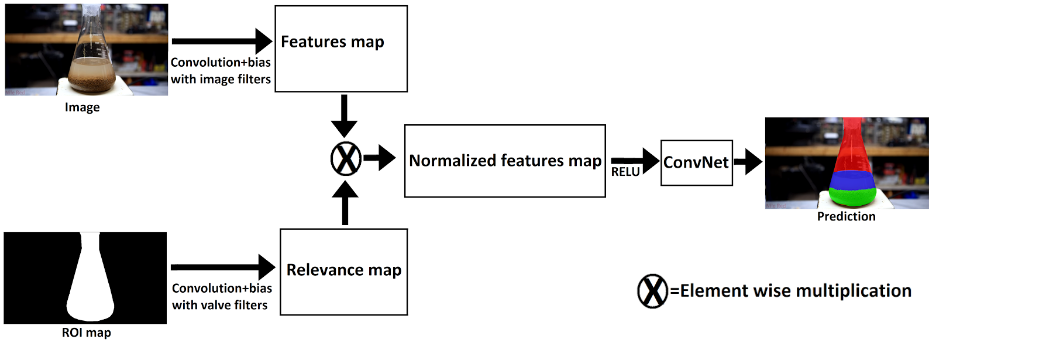
<br>

### Pre-processing
The dataset provided consists of the depth and rgb videos. Both types of videos will be used in this case. The rgb video will be used as the main image, the depth video will be used to generate an ROI binary image (white for ROI, black for background). 
<br>
To convert the depth video to ROI video, threshold and dilation algorithms are used. For the threshold algorithm, pixels that are greater than 20 in value are regarded as ROI. Dilation of 1 iteration is done to close up any gaps within the ROI. 


In [6]:
# Edit the TRAIN and VAL path into the correct directory
TRAIN_PATH = "dataset/train/"
VAL_PATH = "dataset/val/"
files_train = os.listdir(TRAIN_PATH)
filtered_train = [file for file in files_train if "depth" in file]
files_val = os.listdir(VAL_PATH)
filtered_val = [file for file in files_val if "depth" in file]

In [7]:
# Pre-processing to generate ROI Images
target1 = "signer0_sample1_depth.mp4"
def generate_roi(filter_path, filtered):
    for filename in tqdm(filtered):
        name = filter_path + filename 
        cap = cv2.VideoCapture(name)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 960)

        filename = name.replace("depth","roi")
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter(filename, fourcc, 30, (512, 512))

        while True:
            _, frame = cap.read()
            if frame is None:
                break
            output = frame.copy()
            retval,thresh = cv2.threshold(frame, 20, 255, cv2.THRESH_BINARY)
            kernel = np.ones((5,5),np.uint8)
            dilation = cv2.dilate(thresh,kernel,iterations = 1)
            out.write(dilation)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

        out.release()


# generate_roi(TRAIN_PATH, filtered_train)
# generate_roi(VAL_PATH, filtered_val)

## Dataset Class


In [3]:
class AUTSLDatasetROI(Dataset):
    '''
    Dataset for the AUTSL data
    '''
    
    def __init__(self, data_type, max_frame_no, num_class=226 ,frame_interval = 1, file_percentage = 1.0, data_path ="./dataset/" ):
        self.data_type = data_type
        self.frame_interval = frame_interval
        self.data_path = data_path+self.data_type+"/"
        self.label_path = data_path + self.data_type+"_labels.csv"

        df = pd.read_csv(self.label_path,names = ["file_name", "label"])
        self.num_class = num_class  
        self.df = df[df.label < self.num_class]
        self.df["file"] = self.df.file_name + "_color.mp4"
        
        self.file_ls = self.df.file.to_list()
        self.data_length = len(self.file_ls)
    
        self.max_frame_no = max_frame_no
        self.device = "cuda"
        
    def Describe(self):
        msg = "AUTSL Dataset\n"
        print(msg)
        
    def GetLabel(self, file):
        return self.df[self.df.file ==file]["label"].values[0]
    
    def GetVideoArray(self, file_name):

        cap = cv2.VideoCapture(self.data_path + file_name)   # capturing the video from the given path
        video_arr = []
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % self.frame_interval == 0):
                # Converting to tensor
                frame =  torchvision.transforms.functional.to_tensor(frame).float().to(self.device)
                frame = frame.unsqueeze(0)
                frame =  F.interpolate(frame, (128,128), mode='bilinear')
                frame = frame.squeeze(0)
                video_arr.append(frame)
        cap.release()

    
        if len(video_arr)<self.max_frame_no:
            empty_frame = torch.zeros((3,128,128)).to(self.device)
            padding  = [empty_frame]*(self.max_frame_no-len(video_arr))
            video_arr+=padding

        return torch.stack(video_arr) 
        
    def __len__(self):
        return self.data_length
    
    def __getitem__(self, index):
        '''
        Return 4D array consists of all the frame of the video image AND the label
        '''
        file_name = os.path.basename(self.file_ls[index])
        d_file_name = file_name.replace("color","roi")
        
        video_arr = self.GetVideoArray(file_name)
        label = self.GetLabel(file_name) #slice to get just the name without file ext and file type
        videoroi_arr = self.GetVideoArray(file_name.replace("color","roi"))
        file_name.replace("roi","color")
        return video_arr, videoroi_arr, label
        
    def get_max(self):
        max_length = 0
        for i in tqdm(range(len(self))):
            video, label = self[i]
            if video.shape[0]>max_length:
                max_length = video.shape[0]
        return max_length
    


In [5]:
torch.manual_seed(0)

batch_size = 1
num_classes = 30

trainROI_autsl = AUTSLDatasetROI("train", int(156/2), num_classes, frame_interval=4)
valROI_autsl = AUTSLDatasetROI("val", int(114/2), num_classes, frame_interval=4)
trainroiloader = DataLoader(trainROI_autsl, batch_size=batch_size, shuffle=True)
valroiloader = DataLoader(valROI_autsl, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Baseline model

In the next section, we will try to modify the baseline model from the "AUTSL: A Large Scale Multi-modal Turkish Sign Language Dataset and Baseline Methods" paper.<br>
The valve filter model architecture diagram is as shown below. 

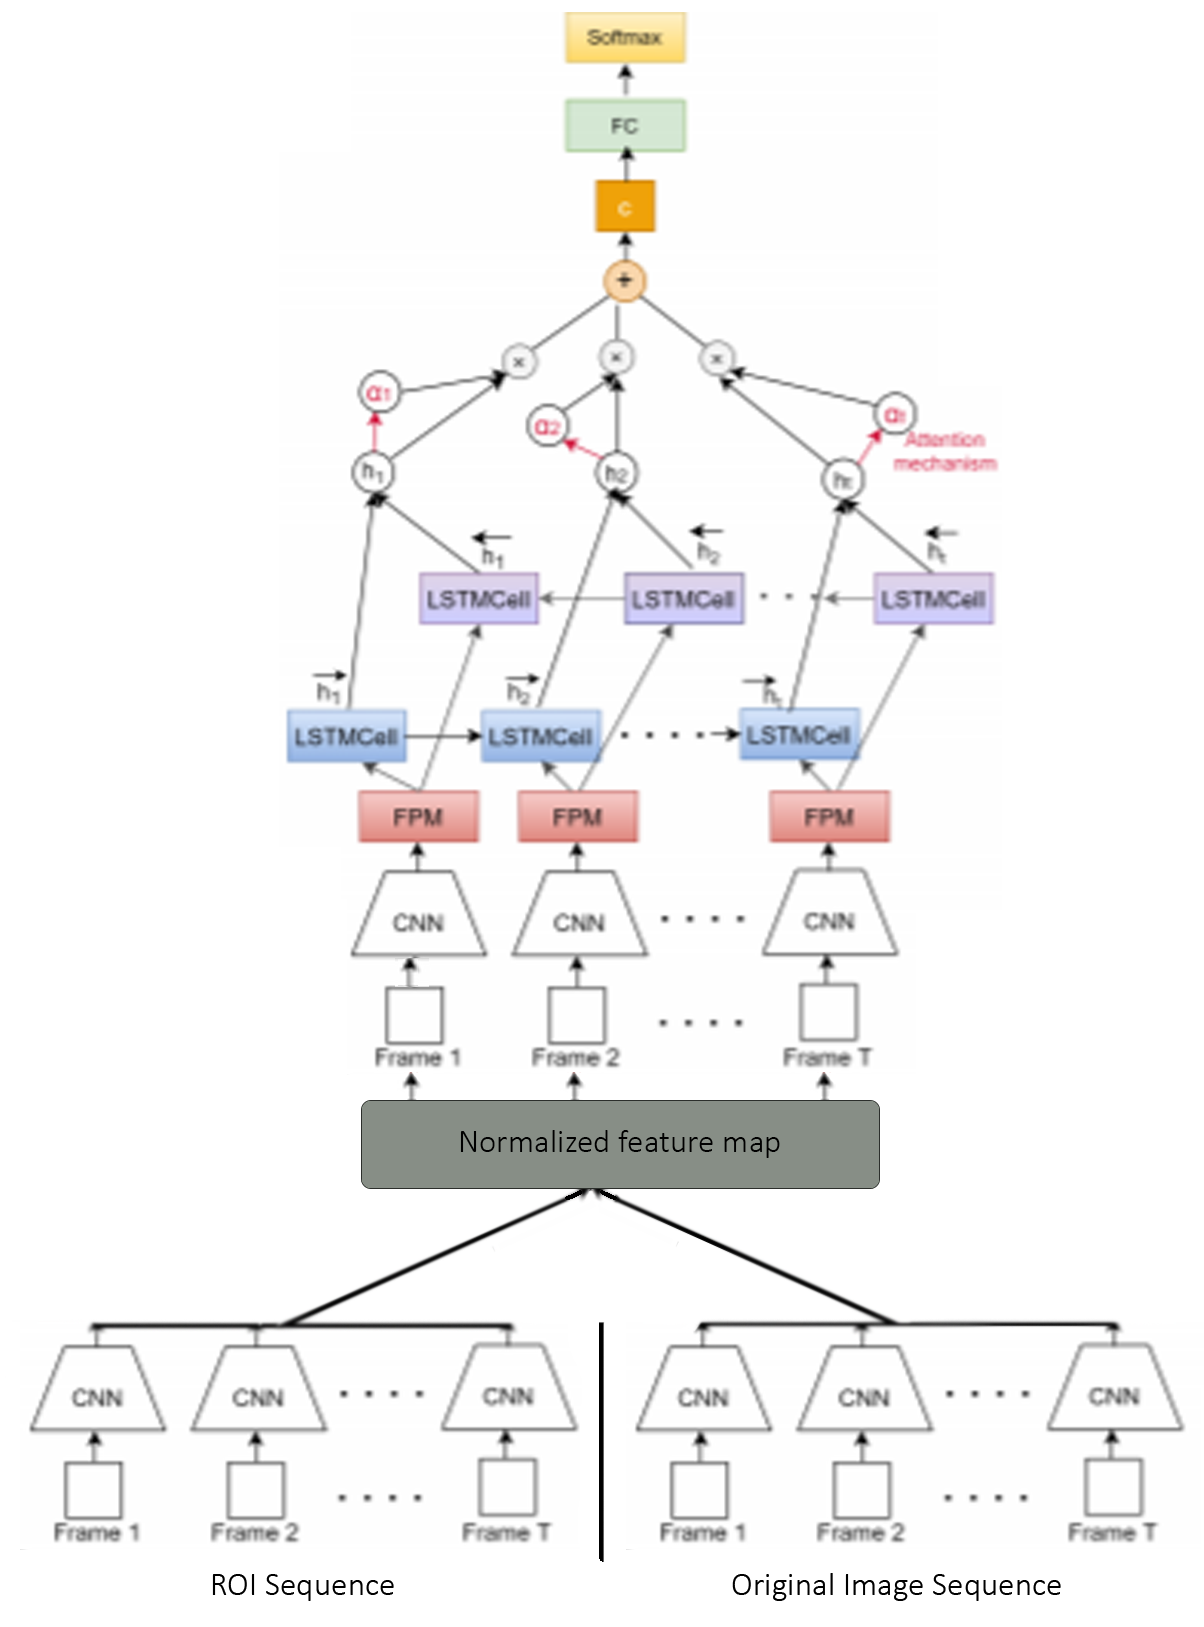

In [10]:
from scipy.stats import truncnorm 
VGG_MEAN = [103.939, 116.779, 123.68]


class cnn_vf(nn.Module):
    def __init__(self):
        super(cnn_vf, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.conv1_0 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=True)
        self.conv1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.vggmiddle = nn.Sequential(*list(vgg.features.children())[2:-5])
        
        for param in self.vggmiddle.parameters():
            param.requires_grad = False
        
        self.vggmiddle.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.vggmiddle.add_module("relu5_2", nn.ReLU(inplace=True))
        self.vggmiddle.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.vggmiddle.add_module("relu5_3", nn.ReLU(inplace=True))
        
    def forward(self, rgb, roi):
        '''
        Input shape = (batchsize, seq, 3, h, w)
        '''
#         print("Input rgb: ",rgb.shape)
#         print("Input roi: ",roi.shape)
        red,green,blue = rgb[:,0:1,:,:],rgb[:,1:2,:,:],rgb[:,2:,:,:]
#         print(red.shape,blue.shape,green.shape)
        bgr = torch.cat((blue - VGG_MEAN[0],green - VGG_MEAN[1], red - VGG_MEAN[2]),1)
#         print("BGR: ",bgr.shape)
        features_map = self.conv1_0(bgr)
#         print("features map: ",features_map.shape)
        relevance_map = self.conv1_1(roi)
#         print("relevance_map: ",relevance_map.shape)
        norm_features_map = features_map * relevance_map        
#         print("norm_features_map: ",norm_features_map.shape)
        output = self.relu1(norm_features_map)
        output = self.vggmiddle(output)
        return output
    
        
class fpm(nn.Module):
    def __init__(self):
        super(fpm, self).__init__()
        self.pool1_0 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1,dilation=2)
        self.conv1_1 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=1)
        self.conv2_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=1)
        self.conv3_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=2,dilation=2)
        self.conv4_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=4,dilation=4)
        
    def forward(self, x):
        '''
        Input shape = (batchsize, seq, 512, 16, 16)
        '''
        x_1 = self.pool1_0(x)
        x_1 = F.relu(self.conv1_1(x_1))
        x_2 = F.relu(self.conv2_0(x))
        x_3 = F.relu(self.conv3_0(x))
        x_4 = F.relu(self.conv4_0(x))
        
        out = torch.cat([x_1,x_2,x_3,x_4], dim=1)
        
        return out

    
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional = True):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True , bidirectional=self.bidirectional)
    
    def forward(self, inputs, hidden):
        output, hidden_state = self.lstm(inputs, hidden)
        return output, hidden_state 
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size), torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size))
    
    
class attention(nn.Module):
    def __init__(self):
        super(attention, self).__init__()
        self.dropout_p = 0.25
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.dropout2 = nn.Dropout(self.dropout_p)
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 1, bias=False)
        
    def forward(self, x):
        hidden = x
        x = torch.tanh(self.linear1(x))
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.softmax(x, dim=len(x.shape)-1)
        c = torch.sum(x*hidden, dim=1)
        return c
    
    

    
class BaselineModel(nn.Module):
    def __init__(self, num_classes):
        super(BaselineModel, self).__init__()
        self.bidirectional = True
        self.lstm_hiddensize = 512
        self.dropout_p = 0.25
        
        self.cnn = cnn_vf()
        self.fpm = fpm()
        self.lstm = lstm(512, self.lstm_hiddensize, self.bidirectional)
        self.attn = attention()
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.fc = nn.Linear(1024,num_classes)
        
        
    def forward(self,x,roi):
        embedding_output = []
        for i in range(x.size(1)):
            x_i = self.cnn(x[:,i,:,:,:],roi[:,i,:,:,:])
            x_i = self.fpm(x_i)
            x_i = x_i.mean([-2, -1]) #Global Average Pooling
            embedding_output.append(x_i)
        embedding_output = torch.stack(embedding_output, dim=1)
        
        h_0, h_1 = self.lstm.init_hidden(embedding_output.shape[0])
        h_0 = h_0.to("cuda")
        h_1 = h_1.to("cuda")
        
        output, (final_hidden_state, final_cell_state) = self.lstm(embedding_output, (h_0,h_1)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
        c = self.attn(output)
        output = self.dropout1(self.fc(c))
        output = F.log_softmax(output, dim=len(output.shape)-1)
        
        return output
    

In [11]:
model = BaselineModel(num_classes)
# x = torch.rand((5, 4, 3, 256, 256))
summary(model)

# Define Parameter here:
model_type = "valve_filter"
model_path = "./model/"
n_epochs = 5
lr = 1e-5
steps = 0 
print_every = 400
validate_every = 400
device = "cuda"

train_loss_ls = []
val_loss_ls = []


time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )
model.to(device)

Layer (type:depth-idx)                   Param #
├─cnn_vf: 1-1                            --
|    └─Conv2d: 2-1                       1,792
|    └─Conv2d: 2-2                       1,792
|    └─ReLU: 2-3                         --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-1                  (36,928)
|    |    └─ReLU: 3-2                    --
|    |    └─MaxPool2d: 3-3               --
|    |    └─Conv2d: 3-4                  (73,856)
|    |    └─ReLU: 3-5                    --
|    |    └─Conv2d: 3-6                  (147,584)
|    |    └─ReLU: 3-7                    --
|    |    └─MaxPool2d: 3-8               --
|    |    └─Conv2d: 3-9                  (295,168)
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 (590,080)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─MaxPool2d: 3-15              --
|    |    └─Conv2d: 3-16 

BaselineModel(
  (cnn): cnn_vf(
    (conv1_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (vggmiddle): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, ke

In [17]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    with tqdm(testloader, position=0, leave=False) as progress_bar:          
        for images,roi,labels in progress_bar:
            roi, images, labels = roi.to(device), images.to(device), labels.to(device)
            output = model(images,roi)
            test_loss += criterion(output, labels).item()

            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy


def test(model, testloader, device='cuda'):  
    model.to(device)
    accuracy = 0

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
                    
            output = model(images,roi)
            
            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()

            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
#         recall = metrics.recall(confusion_matrix, num_classes)
#         precision = metrics.precision(confusion_matrix, num_classes)
#         f1 = metrics.f1(confusion_matrix, num_classes)
        print('Testing accuracy: {:.3f}'.format(accuracy/len(testloader)))
        print(f'Testing recall: {recall:.3f}')
        print(f'Testing precision: {precision:.3f}')
        print(f'Testing f1: {f1:.3f}')

    return accuracy, confusion_matrix


def train(model, model_name, batch_size, n_epochs, lr, trainroi_loader, valroi_loader, saved_model_path, device = "cuda"):
    start_time = datetime.now()
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr= lr)

    train_loss_ls = []
    val_loss_ls = []
    accuracy_hist = []

    best_accuracy = 0
    best_recall = 0
    best_accuracy_weights = None
    best_recall_weights = None
    
    steps = 0
    
    running_loss = 0.0
    running_loss2 = 0.0
    
    for e in range(n_epochs):  # loop over the dataset multiple times

        # Training
        model.train()
        train_it= iter(trainroi_loader)
        for it in tqdm(range(len(trainroi_loader))):
            images,roi,labels = next(train_it)
            steps += 1
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(images,roi)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss2 += loss.item()

            if steps % validate_every == 0:

                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, valroi_loader, criterion, device)
                
                accuracy_hist.append(accuracy)
                    
                running_loss /= validate_every

                time_elapsed = (datetime.now() - start_time)
                tqdm.write(f'===Epoch: {e+1}===')
                tqdm.write(f'== Loss: {running_loss:.3f} Time: {datetime.now()} Elapsed: {time_elapsed}')    
                tqdm.write(f'== Val Loss: {test_loss/len(valroi_loader):.3f} Val Accuracy: {accuracy/len(valroi_loader):.3f}') 
                if accuracy > best_accuracy:
                    best_accuracy_weights = model.state_dict()
                    best_accuracy = accuracy
                    tqdm.write(f'\n=== BEST ACCURACY!!! ===')

                train_loss_ls.append(running_loss) #/print_every
                val_loss_ls.append(test_loss/len(valroi_loader))
                running_loss = 0      
                
                # Make sure training is back on
                model.train()
                
            elif  steps % print_every == 0:
                print("Epoch: {}/{} - ".format(e+1, n_epochs), "Training Loss: {:.3f} - ".format(running_loss2/print_every))
                running_loss2 = 0
                    
        filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
        torch.save(model, filepath)

    print("Finished training")
    
    fig, axs = plt.subplots(2,figsize=(10,15))
    
    axs[0].plot(train_loss_ls, label = "train_loss")
    axs[0].plot(val_loss_ls, label = "val_loss")
    axs[0].legend()
    
    axs[1].plot(train_acc_ls,label = "train_acc")
    axs[1].plot(val_acc_ls,label = "val_acc")
    axs[1].legend()

    fig.savefig(saved_model_path+'history.png')
    fig.show()
    return model.state_dict(), (train_loss_ls, val_loss_ls,val_acc_ls,train_acc_ls)



In [ ]:
last_weights, best_weights = train(model, "baseline", 1, 30, lr, trainroiloader,valroiloader, saved_model_path=current_model_path)

 11%|█         | 400/3696 [06:49<52:18:03, 57.12s/it]

===Epoch: 1===
== Loss: 3.527 Time: 2021-04-30 13:55:02.226987 Elapsed: 0:06:49.563243
== Val Loss: 3.412 Val Accuracy: 0.062

=== BEST ACCURACY!!! ===


 22%|██▏       | 800/3696 [13:38<46:04:22, 57.27s/it]

===Epoch: 1===
== Loss: 3.463 Time: 2021-04-30 14:01:50.992151 Elapsed: 0:13:38.336421
== Val Loss: 3.401 Val Accuracy: 0.036


 32%|███▏      | 1200/3696 [20:29<39:24:21, 56.84s/it]

===Epoch: 1===
== Loss: 3.446 Time: 2021-04-30 14:08:41.773206 Elapsed: 0:20:29.110485
== Val Loss: 3.373 Val Accuracy: 0.061


 43%|████▎     | 1600/3696 [27:11<32:22:28, 55.61s/it]

===Epoch: 1===
== Loss: 3.393 Time: 2021-04-30 14:15:24.258944 Elapsed: 0:27:11.601999
== Val Loss: 3.309 Val Accuracy: 0.074

=== BEST ACCURACY!!! ===


 54%|█████▍    | 2000/3696 [33:58<26:39:06, 56.57s/it]

===Epoch: 1===
== Loss: 3.346 Time: 2021-04-30 14:22:10.782650 Elapsed: 0:33:58.127263
== Val Loss: 3.254 Val Accuracy: 0.107

=== BEST ACCURACY!!! ===


 65%|██████▍   | 2400/3696 [43:44<33:53:01, 94.12s/it]

===Epoch: 1===
== Loss: 3.286 Time: 2021-04-30 14:31:57.107468 Elapsed: 0:43:44.451657
== Val Loss: 3.227 Val Accuracy: 0.047


 76%|███████▌  | 2800/3696 [55:52<21:35:58, 86.78s/it]

===Epoch: 1===
== Loss: 3.256 Time: 2021-04-30 14:44:04.964107 Elapsed: 0:55:52.305939
== Val Loss: 3.130 Val Accuracy: 0.114

=== BEST ACCURACY!!! ===


 87%|████████▋ | 3200/3696 [1:07:48<11:32:25, 83.76s/it]

===Epoch: 1===
== Loss: 3.204 Time: 2021-04-30 14:56:01.511014 Elapsed: 1:07:48.851001
== Val Loss: 3.042 Val Accuracy: 0.128

=== BEST ACCURACY!!! ===


 97%|█████████▋| 3600/3696 [1:19:59<2:22:59, 89.37s/it] 

===Epoch: 1===
== Loss: 3.122 Time: 2021-04-30 15:08:12.615840 Elapsed: 1:19:59.956615
== Val Loss: 2.981 Val Accuracy: 0.137

=== BEST ACCURACY!!! ===


100%|██████████| 3696/3696 [1:21:00<00:00,  1.31s/it]  
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BaselineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type cnn_vf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type fpm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ +

===Epoch: 2===
== Loss: 3.070 Time: 2021-04-30 15:15:18.493162 Elapsed: 1:27:05.837063
== Val Loss: 2.954 Val Accuracy: 0.157

=== BEST ACCURACY!!! ===


 19%|█▉        | 704/3696 [13:18<53:41:09, 64.60s/it]

===Epoch: 2===
== Loss: 2.952 Time: 2021-04-30 15:22:31.155498 Elapsed: 1:34:18.499737
== Val Loss: 2.837 Val Accuracy: 0.157


 30%|██▉       | 1104/3696 [25:30<64:04:39, 89.00s/it]

===Epoch: 2===
== Loss: 2.957 Time: 2021-04-30 15:34:43.824330 Elapsed: 1:46:31.168983
== Val Loss: 2.825 Val Accuracy: 0.171

=== BEST ACCURACY!!! ===


 41%|████      | 1504/3696 [37:40<59:13:51, 97.28s/it]

===Epoch: 2===
== Loss: 2.930 Time: 2021-04-30 15:46:53.685914 Elapsed: 1:58:41.028015
== Val Loss: 2.732 Val Accuracy: 0.218

=== BEST ACCURACY!!! ===


 52%|█████▏    | 1904/3696 [49:18<49:07:07, 98.68s/it]

===Epoch: 2===
== Loss: 2.873 Time: 2021-04-30 15:58:31.727771 Elapsed: 2:10:19.072425
== Val Loss: 2.828 Val Accuracy: 0.209


 62%|██████▏   | 2304/3696 [1:01:07<39:01:12, 100.91s/it]

===Epoch: 2===
== Loss: 2.811 Time: 2021-04-30 16:10:20.388760 Elapsed: 2:22:07.732877
== Val Loss: 2.753 Val Accuracy: 0.163


 73%|███████▎  | 2704/3696 [1:13:04<26:09:23, 94.92s/it] 

===Epoch: 2===
== Loss: 2.808 Time: 2021-04-30 16:22:17.457281 Elapsed: 2:34:04.801932
== Val Loss: 2.757 Val Accuracy: 0.164


 84%|████████▍ | 3104/3696 [1:25:05<13:58:10, 84.95s/it]

===Epoch: 2===
== Loss: 2.803 Time: 2021-04-30 16:34:17.943522 Elapsed: 2:46:05.287305
== Val Loss: 2.802 Val Accuracy: 0.166


 95%|█████████▍| 3504/3696 [1:37:07<4:33:56, 85.61s/it] 

===Epoch: 2===
== Loss: 2.788 Time: 2021-04-30 16:46:20.797960 Elapsed: 2:58:08.139347
== Val Loss: 2.858 Val Accuracy: 0.130


  6%|▌         | 208/3696 [08:58<90:45:27, 93.67s/it]

===Epoch: 3===
== Loss: 2.677 Time: 2021-04-30 16:58:51.639804 Elapsed: 3:10:38.977753
== Val Loss: 2.706 Val Accuracy: 0.202


 16%|█▋        | 608/3696 [16:15<49:19:18, 57.50s/it]

===Epoch: 3===
== Loss: 2.697 Time: 2021-04-30 17:06:08.990987 Elapsed: 3:17:56.334788
== Val Loss: 2.668 Val Accuracy: 0.235

=== BEST ACCURACY!!! ===


 27%|██▋       | 1008/3696 [23:08<42:47:27, 57.31s/it]

===Epoch: 3===
== Loss: 2.657 Time: 2021-04-30 17:13:01.330119 Elapsed: 3:24:48.674369
== Val Loss: 2.609 Val Accuracy: 0.237

=== BEST ACCURACY!!! ===


 38%|███▊      | 1408/3696 [29:59<36:12:54, 56.98s/it]

===Epoch: 3===
== Loss: 2.648 Time: 2021-04-30 17:19:52.202047 Elapsed: 3:31:39.542385
== Val Loss: 2.612 Val Accuracy: 0.244

=== BEST ACCURACY!!! ===


 49%|████▉     | 1808/3696 [36:52<30:00:10, 57.21s/it]

===Epoch: 3===
== Loss: 2.628 Time: 2021-04-30 17:26:45.237059 Elapsed: 3:38:32.576745
== Val Loss: 2.549 Val Accuracy: 0.240


 60%|█████▉    | 2208/3696 [43:55<24:05:31, 58.29s/it]

===Epoch: 3===
== Loss: 2.656 Time: 2021-04-30 17:33:48.630153 Elapsed: 3:45:35.971248
== Val Loss: 2.613 Val Accuracy: 0.225


 71%|███████   | 2608/3696 [52:37<27:01:51, 89.44s/it]

===Epoch: 3===
== Loss: 2.508 Time: 2021-04-30 17:42:30.063499 Elapsed: 3:54:17.406020
== Val Loss: 2.614 Val Accuracy: 0.211


 81%|████████▏ | 3008/3696 [1:04:49<16:31:08, 86.44s/it]

===Epoch: 3===
== Loss: 2.461 Time: 2021-04-30 17:54:42.889388 Elapsed: 4:06:30.222985
== Val Loss: 2.604 Val Accuracy: 0.260

=== BEST ACCURACY!!! ===


 92%|█████████▏| 3408/3696 [1:16:57<6:41:38, 83.67s/it] 

===Epoch: 3===
== Loss: 2.487 Time: 2021-04-30 18:06:50.676922 Elapsed: 4:18:38.020248
== Val Loss: 2.641 Val Accuracy: 0.258


  3%|▎         | 112/3696 [07:25<93:59:58, 94.42s/it]

===Epoch: 4===
== Loss: 2.421 Time: 2021-04-30 18:19:39.835434 Elapsed: 4:31:27.180024
== Val Loss: 2.489 Val Accuracy: 0.270

=== BEST ACCURACY!!! ===


 14%|█▍        | 512/3696 [20:24<88:12:41, 99.74s/it]

===Epoch: 4===
== Loss: 2.439 Time: 2021-04-30 18:32:39.260080 Elapsed: 4:44:26.604589
== Val Loss: 2.705 Val Accuracy: 0.260


 25%|██▍       | 912/3696 [33:21<83:58:19, 108.58s/it]

===Epoch: 4===
== Loss: 2.509 Time: 2021-04-30 18:45:36.064878 Elapsed: 4:57:23.405339
== Val Loss: 2.520 Val Accuracy: 0.258


 35%|███▌      | 1312/3696 [45:50<68:50:23, 103.95s/it]

===Epoch: 4===
== Loss: 2.502 Time: 2021-04-30 18:58:05.334394 Elapsed: 5:09:52.671916
== Val Loss: 2.707 Val Accuracy: 0.266


 46%|████▋     | 1712/3696 [58:46<59:44:08, 108.39s/it]

===Epoch: 4===
== Loss: 2.360 Time: 2021-04-30 19:11:00.881959 Elapsed: 5:22:48.213690
== Val Loss: 2.366 Val Accuracy: 0.327

=== BEST ACCURACY!!! ===


 57%|█████▋    | 2112/3696 [1:07:37<28:50:02, 65.53s/it]

===Epoch: 4===
== Loss: 2.355 Time: 2021-04-30 19:19:52.058186 Elapsed: 5:31:39.398394
== Val Loss: 2.371 Val Accuracy: 0.313


 68%|██████▊   | 2512/3696 [1:14:39<19:15:57, 58.58s/it]

===Epoch: 4===
== Loss: 2.365 Time: 2021-04-30 19:26:53.792063 Elapsed: 5:38:41.136643
== Val Loss: 2.543 Val Accuracy: 0.280


 79%|███████▉  | 2912/3696 [1:21:39<12:24:15, 56.96s/it]

===Epoch: 4===
== Loss: 2.263 Time: 2021-04-30 19:33:53.766648 Elapsed: 5:45:41.106784
== Val Loss: 2.492 Val Accuracy: 0.282


 90%|████████▉ | 3312/3696 [1:28:41<6:19:28, 59.29s/it] 

===Epoch: 4===
== Loss: 2.372 Time: 2021-04-30 19:40:55.807296 Elapsed: 5:52:43.144045
== Val Loss: 2.595 Val Accuracy: 0.275


  0%|          | 16/3696 [03:23<60:09:03, 58.84s/it]

===Epoch: 5===
== Loss: 2.349 Time: 2021-04-30 19:48:05.242175 Elapsed: 5:59:52.584113
== Val Loss: 2.635 Val Accuracy: 0.310


 11%|█▏        | 416/3696 [10:30<53:20:31, 58.55s/it]

===Epoch: 5===
== Loss: 2.290 Time: 2021-04-30 19:55:12.022005 Elapsed: 6:06:59.362154
== Val Loss: 2.533 Val Accuracy: 0.310


 22%|██▏       | 816/3696 [17:22<44:17:01, 55.35s/it]

===Epoch: 5===
== Loss: 2.208 Time: 2021-04-30 20:02:04.668007 Elapsed: 6:13:52.012044
== Val Loss: 2.418 Val Accuracy: 0.325


 33%|███▎      | 1216/3696 [24:06<38:33:18, 55.97s/it]

===Epoch: 5===
== Loss: 2.121 Time: 2021-04-30 20:08:48.699794 Elapsed: 6:20:36.042784
== Val Loss: 2.455 Val Accuracy: 0.304


 44%|████▎     | 1616/3696 [30:49<32:02:29, 55.46s/it]

===Epoch: 5===
== Loss: 2.178 Time: 2021-04-30 20:15:31.274448 Elapsed: 6:27:18.616950
== Val Loss: 2.381 Val Accuracy: 0.304


 55%|█████▍    | 2016/3696 [37:31<25:58:14, 55.65s/it]

===Epoch: 5===
== Loss: 2.163 Time: 2021-04-30 20:22:13.031951 Elapsed: 6:34:00.373444
== Val Loss: 2.380 Val Accuracy: 0.287


 65%|██████▌   | 2416/3696 [44:12<19:39:41, 55.30s/it]

===Epoch: 5===
== Loss: 2.215 Time: 2021-04-30 20:28:54.334435 Elapsed: 6:40:41.678279
== Val Loss: 2.425 Val Accuracy: 0.311


 76%|███████▌  | 2816/3696 [50:54<13:34:17, 55.52s/it]

===Epoch: 5===
== Loss: 2.130 Time: 2021-04-30 20:35:35.983188 Elapsed: 6:47:23.326696
== Val Loss: 2.431 Val Accuracy: 0.285


 87%|████████▋ | 3216/3696 [57:31<7:14:39, 54.33s/it] 

===Epoch: 5===
== Loss: 2.224 Time: 2021-04-30 20:42:13.904280 Elapsed: 6:54:01.246182
== Val Loss: 2.652 Val Accuracy: 0.298


 98%|█████████▊| 3616/3696 [1:04:14<1:14:06, 55.58s/it]

===Epoch: 5===
== Loss: 2.083 Time: 2021-04-30 20:48:56.405016 Elapsed: 7:00:43.749008
== Val Loss: 2.436 Val Accuracy: 0.325


  9%|▊         | 320/3696 [05:55<51:17:32, 54.70s/it]

===Epoch: 6===
== Loss: 2.151 Time: 2021-04-30 20:55:34.824355 Elapsed: 7:07:22.162240
== Val Loss: 2.267 Val Accuracy: 0.310


 19%|█▉        | 720/3696 [12:31<45:01:46, 54.47s/it]

===Epoch: 6===
== Loss: 2.069 Time: 2021-04-30 21:02:11.247947 Elapsed: 7:13:58.591068
== Val Loss: 2.475 Val Accuracy: 0.292


 30%|███       | 1120/3696 [19:13<39:38:40, 55.40s/it]

===Epoch: 6===
== Loss: 2.080 Time: 2021-04-30 21:08:52.811713 Elapsed: 7:20:40.155879
== Val Loss: 2.405 Val Accuracy: 0.332

=== BEST ACCURACY!!! ===


 41%|████      | 1520/3696 [25:55<33:34:24, 55.54s/it]

===Epoch: 6===
== Loss: 2.094 Time: 2021-04-30 21:15:35.419535 Elapsed: 7:27:22.761265
== Val Loss: 2.373 Val Accuracy: 0.273


 52%|█████▏    | 1920/3696 [32:36<27:00:24, 54.74s/it]

===Epoch: 6===
== Loss: 2.118 Time: 2021-04-30 21:22:16.375976 Elapsed: 7:34:03.720514
== Val Loss: 2.370 Val Accuracy: 0.337

=== BEST ACCURACY!!! ===


 63%|██████▎   | 2320/3696 [39:13<20:56:44, 54.80s/it]

===Epoch: 6===
== Loss: 2.028 Time: 2021-04-30 21:28:53.644098 Elapsed: 7:40:40.986375
== Val Loss: 2.292 Val Accuracy: 0.310


 74%|███████▎  | 2720/3696 [45:56<15:04:48, 55.62s/it]

===Epoch: 6===
== Loss: 2.098 Time: 2021-04-30 21:35:36.597831 Elapsed: 7:47:23.941972
== Val Loss: 2.452 Val Accuracy: 0.310


 84%|████████▍ | 3120/3696 [52:36<8:46:59, 54.90s/it] 

===Epoch: 6===
== Loss: 1.880 Time: 2021-04-30 21:42:16.350778 Elapsed: 7:54:03.693903
== Val Loss: 2.507 Val Accuracy: 0.308


 95%|█████████▌| 3520/3696 [59:14<2:41:13, 54.97s/it]

===Epoch: 6===
== Loss: 1.953 Time: 2021-04-30 21:48:54.505754 Elapsed: 8:00:41.847124
== Val Loss: 2.420 Val Accuracy: 0.296


  6%|▌         | 224/3696 [05:06<53:41:45, 55.68s/it]

===Epoch: 7===
== Loss: 1.938 Time: 2021-04-30 21:55:38.498266 Elapsed: 8:07:25.835619
== Val Loss: 2.458 Val Accuracy: 0.327


 17%|█▋        | 624/3696 [11:50<47:27:02, 55.61s/it]

===Epoch: 7===
== Loss: 1.881 Time: 2021-04-30 22:02:22.396701 Elapsed: 8:14:09.736615
== Val Loss: 2.438 Val Accuracy: 0.344

=== BEST ACCURACY!!! ===


 28%|██▊       | 1024/3696 [18:32<40:48:03, 54.97s/it]

===Epoch: 7===
== Loss: 1.972 Time: 2021-04-30 22:09:04.001657 Elapsed: 8:20:51.345430
== Val Loss: 2.564 Val Accuracy: 0.374

=== BEST ACCURACY!!! ===


 39%|███▊      | 1424/3696 [25:08<34:14:17, 54.25s/it]

===Epoch: 7===
== Loss: 1.811 Time: 2021-04-30 22:15:40.025739 Elapsed: 8:27:27.366670
== Val Loss: 2.506 Val Accuracy: 0.330


 49%|████▉     | 1824/3696 [31:52<29:00:20, 55.78s/it]

===Epoch: 7===
== Loss: 1.870 Time: 2021-04-30 22:22:24.673925 Elapsed: 8:34:12.012868
== Val Loss: 2.311 Val Accuracy: 0.346


 60%|██████    | 2224/3696 [38:41<23:04:50, 56.45s/it]

===Epoch: 7===
== Loss: 1.794 Time: 2021-04-30 22:29:12.895915 Elapsed: 8:41:00.239772
== Val Loss: 2.422 Val Accuracy: 0.315


 71%|███████   | 2624/3696 [45:25<16:34:24, 55.66s/it]

===Epoch: 7===
== Loss: 1.921 Time: 2021-04-30 22:35:57.050974 Elapsed: 8:47:44.390782
== Val Loss: 2.353 Val Accuracy: 0.325


 82%|████████▏ | 3024/3696 [52:10<10:23:30, 55.67s/it]

===Epoch: 7===
== Loss: 1.915 Time: 2021-04-30 22:42:42.307896 Elapsed: 8:54:29.648943
== Val Loss: 2.276 Val Accuracy: 0.327


 93%|█████████▎| 3424/3696 [58:52<4:10:42, 55.30s/it] 

===Epoch: 7===
== Loss: 1.819 Time: 2021-04-30 22:49:24.205716 Elapsed: 9:01:11.549622
== Val Loss: 2.494 Val Accuracy: 0.370


  3%|▎         | 128/3696 [04:13<54:59:46, 55.49s/it]

===Epoch: 8===
== Loss: 1.811 Time: 2021-04-30 22:56:08.683129 Elapsed: 9:07:56.027301
== Val Loss: 2.382 Val Accuracy: 0.388

=== BEST ACCURACY!!! ===


 14%|█▍        | 528/3696 [10:55<48:59:33, 55.67s/it]

===Epoch: 8===
== Loss: 1.918 Time: 2021-04-30 23:02:50.740560 Elapsed: 9:14:38.079191
== Val Loss: 2.425 Val Accuracy: 0.363


 25%|██▌       | 928/3696 [17:41<43:08:51, 56.12s/it]

===Epoch: 8===
== Loss: 1.885 Time: 2021-04-30 23:09:36.601724 Elapsed: 9:21:23.944023
== Val Loss: 2.530 Val Accuracy: 0.322


 36%|███▌      | 1328/3696 [24:29<36:51:33, 56.04s/it]

===Epoch: 8===
== Loss: 1.751 Time: 2021-04-30 23:16:24.306350 Elapsed: 9:28:11.650453
== Val Loss: 2.165 Val Accuracy: 0.349


 47%|████▋     | 1728/3696 [31:11<30:19:08, 55.46s/it]

===Epoch: 8===
== Loss: 1.760 Time: 2021-04-30 23:23:06.360561 Elapsed: 9:34:53.698896
== Val Loss: 2.523 Val Accuracy: 0.349


 58%|█████▊    | 2128/3696 [37:54<24:08:53, 55.44s/it]

===Epoch: 8===
== Loss: 1.789 Time: 2021-04-30 23:29:49.780224 Elapsed: 9:41:37.120634
== Val Loss: 2.364 Val Accuracy: 0.400

=== BEST ACCURACY!!! ===


 68%|██████▊   | 2528/3696 [44:38<18:07:41, 55.87s/it]

===Epoch: 8===
== Loss: 1.767 Time: 2021-04-30 23:36:33.837077 Elapsed: 9:48:21.174749
== Val Loss: 2.399 Val Accuracy: 0.381


 79%|███████▉  | 2928/3696 [51:23<11:54:15, 55.80s/it]

===Epoch: 8===
== Loss: 1.649 Time: 2021-04-30 23:43:18.393060 Elapsed: 9:55:05.736789
== Val Loss: 2.347 Val Accuracy: 0.382


 90%|█████████ | 3328/3696 [58:08<5:41:39, 55.71s/it] 

===Epoch: 8===
== Loss: 1.723 Time: 2021-04-30 23:50:03.632119 Elapsed: 10:01:50.972726
== Val Loss: 2.162 Val Accuracy: 0.360


  1%|          | 32/3696 [03:21<56:47:07, 55.79s/it]

===Epoch: 9===
== Loss: 1.738 Time: 2021-04-30 23:56:51.970407 Elapsed: 10:08:39.310507
== Val Loss: 2.604 Val Accuracy: 0.375


 12%|█▏        | 432/3696 [10:09<50:59:24, 56.24s/it]

===Epoch: 9===
== Loss: 1.707 Time: 2021-05-01 00:03:39.176436 Elapsed: 10:15:26.515328
== Val Loss: 2.493 Val Accuracy: 0.325


 23%|██▎       | 832/3696 [16:52<43:38:24, 54.86s/it]

===Epoch: 9===
== Loss: 1.691 Time: 2021-05-01 00:10:22.365857 Elapsed: 10:22:09.702281
== Val Loss: 2.435 Val Accuracy: 0.362


 33%|███▎      | 1232/3696 [23:38<38:18:54, 55.98s/it]

===Epoch: 9===
== Loss: 1.645 Time: 2021-05-01 00:17:08.176928 Elapsed: 10:28:55.519067
== Val Loss: 2.657 Val Accuracy: 0.370


 44%|████▍     | 1632/3696 [30:24<32:00:09, 55.82s/it]

===Epoch: 9===
== Loss: 1.723 Time: 2021-05-01 00:23:54.555557 Elapsed: 10:35:41.891207
== Val Loss: 2.400 Val Accuracy: 0.381


 55%|█████▍    | 2032/3696 [37:09<25:53:29, 56.02s/it]

===Epoch: 9===
== Loss: 1.604 Time: 2021-05-01 00:30:39.123199 Elapsed: 10:42:26.463470
== Val Loss: 2.470 Val Accuracy: 0.403

=== BEST ACCURACY!!! ===


 66%|██████▌   | 2432/3696 [43:54<19:35:45, 55.81s/it]

===Epoch: 9===
== Loss: 1.572 Time: 2021-05-01 00:37:24.562369 Elapsed: 10:49:11.906590
== Val Loss: 2.407 Val Accuracy: 0.370


 77%|███████▋  | 2832/3696 [50:36<13:19:00, 55.49s/it]

===Epoch: 9===
== Loss: 1.541 Time: 2021-05-01 00:44:06.186381 Elapsed: 10:55:53.530691
== Val Loss: 2.328 Val Accuracy: 0.398


 87%|████████▋ | 3232/3696 [57:16<7:08:36, 55.42s/it] 

===Epoch: 9===
== Loss: 1.603 Time: 2021-05-01 00:50:46.315026 Elapsed: 11:02:33.654781
== Val Loss: 2.453 Val Accuracy: 0.382


 98%|█████████▊| 3632/3696 [1:03:52<58:12, 54.57s/it]

===Epoch: 9===
== Loss: 1.577 Time: 2021-05-01 00:57:23.086642 Elapsed: 11:09:10.426967
== Val Loss: 2.366 Val Accuracy: 0.355


  9%|▉         | 336/3696 [06:07<52:01:53, 55.75s/it]

===Epoch: 10===
== Loss: 1.508 Time: 2021-05-01 01:04:06.358321 Elapsed: 11:15:53.699308
== Val Loss: 2.535 Val Accuracy: 0.344


 20%|█▉        | 736/3696 [12:49<45:28:59, 55.32s/it]

===Epoch: 10===
== Loss: 1.429 Time: 2021-05-01 01:10:47.990454 Elapsed: 11:22:35.330695
== Val Loss: 2.567 Val Accuracy: 0.386


 31%|███       | 1136/3696 [19:34<39:56:10, 56.16s/it]

===Epoch: 10===
== Loss: 1.462 Time: 2021-05-01 01:17:33.345379 Elapsed: 11:29:20.685792
== Val Loss: 2.504 Val Accuracy: 0.356


 42%|████▏     | 1536/3696 [26:16<33:21:28, 55.60s/it]

===Epoch: 10===
== Loss: 1.459 Time: 2021-05-01 01:24:15.331247 Elapsed: 11:36:02.667609
== Val Loss: 2.770 Val Accuracy: 0.374


 52%|█████▏    | 1936/3696 [32:58<27:13:09, 55.68s/it]

===Epoch: 10===
== Loss: 1.602 Time: 2021-05-01 01:30:57.258165 Elapsed: 11:42:44.592072
== Val Loss: 2.582 Val Accuracy: 0.360


 63%|██████▎   | 2336/3696 [39:34<20:26:35, 54.11s/it]

===Epoch: 10===
== Loss: 1.522 Time: 2021-05-01 01:37:33.022528 Elapsed: 11:49:20.366500
== Val Loss: 2.323 Val Accuracy: 0.382


 74%|███████▍  | 2736/3696 [46:16<14:47:01, 55.44s/it]

===Epoch: 10===
== Loss: 1.514 Time: 2021-05-01 01:44:15.338509 Elapsed: 11:56:02.676538
== Val Loss: 2.656 Val Accuracy: 0.339


 85%|████████▍ | 3136/3696 [52:58<8:34:51, 55.16s/it] 

===Epoch: 10===
== Loss: 1.616 Time: 2021-05-01 01:50:57.286155 Elapsed: 12:02:44.630808
== Val Loss: 2.428 Val Accuracy: 0.374


 96%|█████████▌| 3536/3696 [59:40<2:29:40, 56.13s/it]

===Epoch: 10===
== Loss: 1.559 Time: 2021-05-01 01:57:39.300302 Elapsed: 12:09:26.644646
== Val Loss: 2.493 Val Accuracy: 0.362


  6%|▋         | 240/3696 [05:22<54:52:59, 57.17s/it]

===Epoch: 11===
== Loss: 1.399 Time: 2021-05-01 02:04:33.054196 Elapsed: 12:16:20.398398
== Val Loss: 2.268 Val Accuracy: 0.374


 17%|█▋        | 640/3696 [12:15<48:30:40, 57.15s/it]

===Epoch: 11===
== Loss: 1.384 Time: 2021-05-01 02:11:25.350707 Elapsed: 12:23:12.695348
== Val Loss: 2.437 Val Accuracy: 0.362


 28%|██▊       | 1040/3696 [19:08<42:27:52, 57.56s/it]

===Epoch: 11===
== Loss: 1.343 Time: 2021-05-01 02:18:19.088815 Elapsed: 12:30:06.424814
== Val Loss: 2.391 Val Accuracy: 0.398


 39%|███▉      | 1440/3696 [26:04<36:34:14, 58.36s/it]

===Epoch: 11===
== Loss: 1.214 Time: 2021-05-01 02:25:14.649362 Elapsed: 12:37:01.980695
== Val Loss: 2.414 Val Accuracy: 0.393


 50%|████▉     | 1840/3696 [32:57<29:33:48, 57.34s/it]

===Epoch: 11===
== Loss: 1.426 Time: 2021-05-01 02:32:07.653466 Elapsed: 12:43:54.997397
== Val Loss: 2.538 Val Accuracy: 0.365


 61%|██████    | 2240/3696 [40:34<25:16:32, 62.49s/it]

===Epoch: 11===
== Loss: 1.514 Time: 2021-05-01 02:39:44.850345 Elapsed: 12:51:32.194382
== Val Loss: 2.856 Val Accuracy: 0.398


 71%|███████▏  | 2640/3696 [50:13<28:59:43, 98.85s/it]

===Epoch: 11===
== Loss: 1.376 Time: 2021-05-01 02:49:23.692524 Elapsed: 13:01:11.025694
== Val Loss: 2.644 Val Accuracy: 0.346


 82%|████████▏ | 3040/3696 [1:02:55<18:02:14, 98.99s/it]

===Epoch: 11===
== Loss: 1.442 Time: 2021-05-01 03:02:05.446910 Elapsed: 13:13:52.782934
== Val Loss: 2.326 Val Accuracy: 0.367


 93%|█████████▎| 3440/3696 [1:15:51<7:13:25, 101.58s/it]

===Epoch: 11===
== Loss: 1.324 Time: 2021-05-01 03:15:01.479171 Elapsed: 13:26:48.819321
== Val Loss: 2.580 Val Accuracy: 0.358


  4%|▍         | 144/3696 [08:14<99:24:04, 100.74s/it]

===Epoch: 12===
== Loss: 1.375 Time: 2021-05-01 03:27:57.302969 Elapsed: 13:39:44.639292
== Val Loss: 2.452 Val Accuracy: 0.429

=== BEST ACCURACY!!! ===


 15%|█▍        | 544/3696 [21:11<88:42:42, 101.32s/it]

===Epoch: 12===
== Loss: 1.270 Time: 2021-05-01 03:40:54.975319 Elapsed: 13:52:42.312078
== Val Loss: 2.457 Val Accuracy: 0.362


 26%|██▌       | 944/3696 [34:05<75:58:38, 99.39s/it] 

===Epoch: 12===
== Loss: 1.191 Time: 2021-05-01 03:53:48.399946 Elapsed: 14:05:35.739779
== Val Loss: 2.594 Val Accuracy: 0.389


 36%|███▋      | 1344/3696 [46:58<65:07:37, 99.68s/it]

===Epoch: 12===
== Loss: 1.151 Time: 2021-05-01 04:06:41.750868 Elapsed: 14:18:29.095146
== Val Loss: 2.455 Val Accuracy: 0.403


 47%|████▋     | 1744/3696 [1:00:01<55:45:49, 102.84s/it]

===Epoch: 12===
== Loss: 1.245 Time: 2021-05-01 04:19:44.934465 Elapsed: 14:31:32.269327
== Val Loss: 2.402 Val Accuracy: 0.422


 58%|█████▊    | 2144/3696 [1:13:01<43:28:40, 100.85s/it]

===Epoch: 12===
== Loss: 1.311 Time: 2021-05-01 04:32:44.564916 Elapsed: 14:44:31.909567
== Val Loss: 2.874 Val Accuracy: 0.379


 69%|██████▉   | 2544/3696 [1:26:01<32:17:39, 100.92s/it]

===Epoch: 12===
== Loss: 1.336 Time: 2021-05-01 04:45:44.438474 Elapsed: 14:57:31.782590
== Val Loss: 2.276 Val Accuracy: 0.396


 80%|███████▉  | 2944/3696 [1:39:05<21:10:44, 101.39s/it]

===Epoch: 12===
== Loss: 1.279 Time: 2021-05-01 04:58:48.429777 Elapsed: 15:10:35.773727
== Val Loss: 2.907 Val Accuracy: 0.408


 90%|█████████ | 3344/3696 [1:52:03<9:55:31, 101.51s/it] 

===Epoch: 12===
== Loss: 1.266 Time: 2021-05-01 05:11:47.132835 Elapsed: 15:23:34.477081
== Val Loss: 2.659 Val Accuracy: 0.389


  1%|▏         | 48/3696 [06:34<104:55:11, 103.54s/it]

===Epoch: 13===
== Loss: 1.300 Time: 2021-05-01 05:24:53.404387 Elapsed: 15:36:40.744019
== Val Loss: 2.674 Val Accuracy: 0.410


 12%|█▏        | 448/3696 [19:40<91:47:25, 101.74s/it]

===Epoch: 13===
== Loss: 1.163 Time: 2021-05-01 05:37:59.382805 Elapsed: 15:49:46.727443
== Val Loss: 2.604 Val Accuracy: 0.349


 23%|██▎       | 848/3696 [32:42<80:17:13, 101.49s/it]

===Epoch: 13===
== Loss: 1.224 Time: 2021-05-01 05:51:01.608960 Elapsed: 16:02:48.953529
== Val Loss: 2.698 Val Accuracy: 0.375


 34%|███▍      | 1248/3696 [45:49<69:44:31, 102.56s/it]

===Epoch: 13===
== Loss: 1.233 Time: 2021-05-01 06:04:09.168010 Elapsed: 16:15:56.504853
== Val Loss: 2.957 Val Accuracy: 0.398


 45%|████▍     | 1648/3696 [53:30<36:51:15, 64.78s/it] 

===Epoch: 13===
== Loss: 1.369 Time: 2021-05-01 06:11:49.452901 Elapsed: 16:23:36.794653
== Val Loss: 2.530 Val Accuracy: 0.420


 55%|█████▌    | 2048/3696 [1:02:58<44:15:18, 96.67s/it]

===Epoch: 13===
== Loss: 1.161 Time: 2021-05-01 06:21:17.931300 Elapsed: 16:33:05.266167
== Val Loss: 2.929 Val Accuracy: 0.393


 66%|██████▌   | 2448/3696 [1:16:05<35:35:44, 102.68s/it]

===Epoch: 13===
== Loss: 1.164 Time: 2021-05-01 06:34:25.262318 Elapsed: 16:46:12.606468
== Val Loss: 2.721 Val Accuracy: 0.401


 77%|███████▋  | 2848/3696 [1:29:07<23:52:14, 101.34s/it]

===Epoch: 13===
== Loss: 1.197 Time: 2021-05-01 06:47:27.155590 Elapsed: 16:59:14.496075
== Val Loss: 2.660 Val Accuracy: 0.400


 88%|████████▊ | 3248/3696 [1:42:15<12:42:31, 102.12s/it]

===Epoch: 13===
== Loss: 1.183 Time: 2021-05-01 07:00:34.580881 Elapsed: 17:12:21.925208
== Val Loss: 2.785 Val Accuracy: 0.396


 99%|█████████▊| 3648/3696 [1:55:10<1:19:25, 99.28s/it]  

===Epoch: 13===
== Loss: 1.136 Time: 2021-05-01 07:13:30.200004 Elapsed: 17:25:17.544493
== Val Loss: 2.373 Val Accuracy: 0.398


 10%|▉         | 352/3696 [12:03<93:35:53, 100.76s/it]

===Epoch: 14===
== Loss: 1.087 Time: 2021-05-01 07:26:27.865404 Elapsed: 17:38:15.209572
== Val Loss: 2.898 Val Accuracy: 0.401


 20%|██        | 752/3696 [25:02<83:05:53, 101.61s/it]

===Epoch: 14===
== Loss: 1.158 Time: 2021-05-01 07:39:26.754626 Elapsed: 17:51:14.096163
== Val Loss: 2.748 Val Accuracy: 0.367


 31%|███       | 1152/3696 [36:32<54:05:52, 76.55s/it]

===Epoch: 14===
== Loss: 1.113 Time: 2021-05-01 07:50:56.909685 Elapsed: 18:02:44.253170
== Val Loss: 2.815 Val Accuracy: 0.393


 42%|████▏     | 1552/3696 [45:14<48:55:56, 82.16s/it]

===Epoch: 14===
== Loss: 1.094 Time: 2021-05-01 07:59:38.735791 Elapsed: 18:11:26.080002
== Val Loss: 2.684 Val Accuracy: 0.401


 53%|█████▎    | 1952/3696 [58:02<48:32:02, 100.18s/it]

===Epoch: 14===
== Loss: 1.306 Time: 2021-05-01 08:12:27.595190 Elapsed: 18:24:14.933435
== Val Loss: 2.961 Val Accuracy: 0.413


 64%|██████▎   | 2352/3696 [1:10:52<37:13:46, 99.72s/it]

===Epoch: 14===
== Loss: 1.125 Time: 2021-05-01 08:25:16.981517 Elapsed: 18:37:04.321879
== Val Loss: 2.724 Val Accuracy: 0.433

=== BEST ACCURACY!!! ===


 74%|███████▍  | 2752/3696 [1:23:48<26:22:16, 100.57s/it]

===Epoch: 14===
== Loss: 1.171 Time: 2021-05-01 08:38:13.375600 Elapsed: 18:50:00.720153
== Val Loss: 2.693 Val Accuracy: 0.379


 85%|████████▌ | 3152/3696 [1:35:35<13:27:28, 89.06s/it] 

===Epoch: 14===
== Loss: 1.060 Time: 2021-05-01 08:49:59.977197 Elapsed: 19:01:47.307365
== Val Loss: 3.094 Val Accuracy: 0.379


 96%|█████████▌| 3552/3696 [1:46:37<3:28:10, 86.74s/it] 

===Epoch: 14===
== Loss: 1.313 Time: 2021-05-01 09:01:02.398454 Elapsed: 19:12:49.742174
== Val Loss: 3.185 Val Accuracy: 0.365


  7%|▋         | 256/3696 [08:49<83:41:30, 87.58s/it]

===Epoch: 15===
== Loss: 0.945 Time: 2021-05-01 09:12:09.399788 Elapsed: 19:23:56.740874
== Val Loss: 3.319 Val Accuracy: 0.370


 18%|█▊        | 656/3696 [22:22<87:20:33, 103.43s/it]

===Epoch: 15===
== Loss: 1.173 Time: 2021-05-01 09:25:42.629050 Elapsed: 19:37:29.967805
== Val Loss: 2.875 Val Accuracy: 0.412


 29%|██▊       | 1056/3696 [31:02<53:25:15, 72.85s/it]

===Epoch: 15===
== Loss: 1.052 Time: 2021-05-01 09:34:23.139032 Elapsed: 19:46:10.483652
== Val Loss: 2.590 Val Accuracy: 0.389


 39%|███▉      | 1456/3696 [39:52<46:41:00, 75.03s/it]

===Epoch: 15===
== Loss: 1.119 Time: 2021-05-01 09:43:12.571460 Elapsed: 19:54:59.914311
== Val Loss: 3.076 Val Accuracy: 0.344


 50%|█████     | 1856/3696 [48:37<37:42:48, 73.79s/it]

===Epoch: 15===
== Loss: 1.130 Time: 2021-05-01 09:51:57.603205 Elapsed: 20:03:44.947275
== Val Loss: 3.247 Val Accuracy: 0.393


 61%|██████    | 2256/3696 [57:23<28:58:37, 72.44s/it]

===Epoch: 15===
== Loss: 1.138 Time: 2021-05-01 10:00:44.271326 Elapsed: 20:12:31.615248
== Val Loss: 3.306 Val Accuracy: 0.381


 72%|███████▏  | 2656/3696 [1:06:14<20:46:28, 71.91s/it]

===Epoch: 15===
== Loss: 1.020 Time: 2021-05-01 10:09:35.196093 Elapsed: 20:21:22.540348
== Val Loss: 2.919 Val Accuracy: 0.413


 83%|████████▎ | 3056/3696 [1:14:57<12:21:22, 69.50s/it]

===Epoch: 15===
== Loss: 1.178 Time: 2021-05-01 10:18:18.006867 Elapsed: 20:30:05.343084
== Val Loss: 2.944 Val Accuracy: 0.363


 94%|█████████▎| 3456/3696 [1:23:54<5:00:01, 75.00s/it] 

===Epoch: 15===
== Loss: 1.137 Time: 2021-05-01 10:27:15.210153 Elapsed: 20:39:02.553019
== Val Loss: 2.813 Val Accuracy: 0.370


  4%|▍         | 160/3696 [06:06<74:03:19, 75.40s/it]

===Epoch: 16===
== Loss: 1.111 Time: 2021-05-01 10:36:07.550915 Elapsed: 20:47:54.894112
== Val Loss: 2.752 Val Accuracy: 0.394


 15%|█▌        | 560/3696 [14:54<65:26:14, 75.12s/it]

===Epoch: 16===
== Loss: 1.111 Time: 2021-05-01 10:44:56.143287 Elapsed: 20:56:43.486860
== Val Loss: 2.989 Val Accuracy: 0.415


 26%|██▌       | 960/3696 [23:44<56:58:24, 74.97s/it]

===Epoch: 16===
== Loss: 1.129 Time: 2021-05-01 10:53:45.820426 Elapsed: 21:05:33.163064
== Val Loss: 2.823 Val Accuracy: 0.391


 37%|███▋      | 1360/3696 [32:27<46:04:04, 71.00s/it]

===Epoch: 16===
== Loss: 1.038 Time: 2021-05-01 11:02:29.367169 Elapsed: 21:14:16.710880
== Val Loss: 2.814 Val Accuracy: 0.351


 48%|████▊     | 1760/3696 [41:12<37:59:30, 70.65s/it]

===Epoch: 16===
== Loss: 1.017 Time: 2021-05-01 11:11:14.188571 Elapsed: 21:23:01.527600
== Val Loss: 3.281 Val Accuracy: 0.382


 58%|█████▊    | 2160/3696 [49:56<29:54:02, 70.08s/it]

===Epoch: 16===
== Loss: 1.032 Time: 2021-05-01 11:19:57.917385 Elapsed: 21:31:45.257956
== Val Loss: 2.760 Val Accuracy: 0.394


 69%|██████▉   | 2560/3696 [58:53<23:20:10, 73.95s/it]

===Epoch: 16===
== Loss: 1.010 Time: 2021-05-01 11:28:54.564730 Elapsed: 21:40:41.903487
== Val Loss: 3.079 Val Accuracy: 0.412


 80%|████████  | 2960/3696 [1:05:45<11:30:33, 56.30s/it]

===Epoch: 16===
== Loss: 1.067 Time: 2021-05-01 11:35:47.405029 Elapsed: 21:47:34.743454
== Val Loss: 3.078 Val Accuracy: 0.410


 91%|█████████ | 3360/3696 [1:12:35<5:14:44, 56.20s/it] 

===Epoch: 16===
== Loss: 0.901 Time: 2021-05-01 11:42:37.433711 Elapsed: 21:54:24.777090
== Val Loss: 2.909 Val Accuracy: 0.412


  2%|▏         | 64/3696 [03:41<56:49:45, 56.33s/it]

===Epoch: 17===
== Loss: 1.100 Time: 2021-05-01 11:49:26.994942 Elapsed: 22:01:14.325844
== Val Loss: 2.736 Val Accuracy: 0.427


 13%|█▎        | 464/3696 [10:31<51:01:43, 56.84s/it]

===Epoch: 17===
== Loss: 1.030 Time: 2021-05-01 11:56:17.454491 Elapsed: 22:08:04.799121
== Val Loss: 3.124 Val Accuracy: 0.441

=== BEST ACCURACY!!! ===


 23%|██▎       | 864/3696 [17:30<46:40:51, 59.34s/it]

===Epoch: 17===
== Loss: 1.002 Time: 2021-05-01 12:03:16.114261 Elapsed: 22:15:03.453707
== Val Loss: 2.990 Val Accuracy: 0.417


 34%|███▍      | 1264/3696 [25:03<40:48:46, 60.41s/it]

===Epoch: 17===
== Loss: 0.997 Time: 2021-05-01 12:10:49.217409 Elapsed: 22:22:36.557679
== Val Loss: 2.816 Val Accuracy: 0.420


 45%|████▌     | 1664/3696 [32:41<34:45:24, 61.58s/it]

===Epoch: 17===
== Loss: 0.985 Time: 2021-05-01 12:18:27.112809 Elapsed: 22:30:14.453426
== Val Loss: 3.143 Val Accuracy: 0.381


 56%|█████▌    | 2064/3696 [40:18<27:42:07, 61.11s/it]

===Epoch: 17===
== Loss: 0.892 Time: 2021-05-01 12:26:03.813815 Elapsed: 22:37:51.156979
== Val Loss: 2.982 Val Accuracy: 0.434


 67%|██████▋   | 2464/3696 [47:55<21:10:22, 61.87s/it]

===Epoch: 17===
== Loss: 0.952 Time: 2021-05-01 12:33:40.949289 Elapsed: 22:45:28.291981
== Val Loss: 2.752 Val Accuracy: 0.408


 77%|███████▋  | 2864/3696 [55:31<14:08:55, 61.22s/it]

===Epoch: 17===
== Loss: 0.891 Time: 2021-05-01 12:41:16.911869 Elapsed: 22:53:04.255079
== Val Loss: 2.851 Val Accuracy: 0.431


 88%|████████▊ | 3264/3696 [1:03:00<7:10:37, 59.81s/it]

===Epoch: 17===
== Loss: 1.101 Time: 2021-05-01 12:48:46.494353 Elapsed: 23:00:33.833799
== Val Loss: 3.498 Val Accuracy: 0.420


 99%|█████████▉| 3664/3696 [1:10:06<32:32, 61.02s/it]  

===Epoch: 17===
== Loss: 1.104 Time: 2021-05-01 12:55:52.542498 Elapsed: 23:07:39.877846
== Val Loss: 2.930 Val Accuracy: 0.450

=== BEST ACCURACY!!! ===


 10%|▉         | 368/3696 [07:11<57:03:30, 61.72s/it]

===Epoch: 18===
== Loss: 0.977 Time: 2021-05-01 13:03:24.956604 Elapsed: 23:15:12.296880
== Val Loss: 2.681 Val Accuracy: 0.427


 21%|██        | 768/3696 [14:37<49:07:50, 60.41s/it]

===Epoch: 18===
== Loss: 0.977 Time: 2021-05-01 13:10:51.714065 Elapsed: 23:22:39.056513
== Val Loss: 2.512 Val Accuracy: 0.427


 32%|███▏      | 1168/3696 [22:09<42:06:40, 59.97s/it]

===Epoch: 18===
== Loss: 0.967 Time: 2021-05-01 13:18:23.393562 Elapsed: 23:30:10.729760
== Val Loss: 2.733 Val Accuracy: 0.420


 42%|████▏     | 1568/3696 [29:41<35:36:40, 60.24s/it]

===Epoch: 18===
== Loss: 1.101 Time: 2021-05-01 13:25:54.779213 Elapsed: 23:37:42.115586
== Val Loss: 3.393 Val Accuracy: 0.439


 53%|█████▎    | 1968/3696 [37:11<29:18:57, 61.07s/it]

===Epoch: 18===
== Loss: 1.024 Time: 2021-05-01 13:33:25.501015 Elapsed: 23:45:12.835920
== Val Loss: 2.755 Val Accuracy: 0.367


 64%|██████▍   | 2368/3696 [44:43<22:10:14, 60.10s/it]

===Epoch: 18===
== Loss: 0.881 Time: 2021-05-01 13:40:57.540414 Elapsed: 23:52:44.880680
== Val Loss: 3.905 Val Accuracy: 0.419


 75%|███████▍  | 2768/3696 [52:15<15:41:09, 60.85s/it]

===Epoch: 18===
== Loss: 1.026 Time: 2021-05-01 13:48:28.898725 Elapsed: 1 day, 0:00:16.243180
== Val Loss: 2.928 Val Accuracy: 0.424


 86%|████████▌ | 3168/3696 [59:43<8:53:58, 60.68s/it] 

===Epoch: 18===
== Loss: 0.959 Time: 2021-05-01 13:55:56.760965 Elapsed: 1 day, 0:07:44.099817
== Val Loss: 3.084 Val Accuracy: 0.405


 97%|█████████▋| 3568/3696 [1:07:19<2:10:38, 61.24s/it]

===Epoch: 18===
== Loss: 1.113 Time: 2021-05-01 14:03:32.909943 Elapsed: 1 day, 0:15:20.249343
== Val Loss: 2.751 Val Accuracy: 0.438


  7%|▋         | 272/3696 [06:16<59:04:29, 62.11s/it]

===Epoch: 19===
== Loss: 0.946 Time: 2021-05-01 14:11:12.172399 Elapsed: 1 day, 0:22:59.508850
== Val Loss: 3.157 Val Accuracy: 0.429


 18%|█▊        | 672/3696 [13:32<49:07:59, 58.49s/it]

===Epoch: 19===
== Loss: 0.917 Time: 2021-05-01 14:18:28.036512 Elapsed: 1 day, 0:30:15.381185
== Val Loss: 2.792 Val Accuracy: 0.415


 29%|██▉       | 1072/3696 [20:22<41:17:43, 56.66s/it]

===Epoch: 19===
== Loss: 0.798 Time: 2021-05-01 14:25:17.722041 Elapsed: 1 day, 0:37:05.060184
== Val Loss: 2.932 Val Accuracy: 0.408


 40%|███▉      | 1472/3696 [27:17<35:11:05, 56.95s/it]

===Epoch: 19===
== Loss: 1.012 Time: 2021-05-01 14:32:12.876706 Elapsed: 1 day, 0:44:00.220438
== Val Loss: 3.378 Val Accuracy: 0.410


 51%|█████     | 1872/3696 [34:07<28:20:05, 55.92s/it]

===Epoch: 19===
== Loss: 1.015 Time: 2021-05-01 14:39:02.969561 Elapsed: 1 day, 0:50:50.313340
== Val Loss: 2.998 Val Accuracy: 0.417


 61%|██████▏   | 2272/3696 [40:54<22:07:08, 55.92s/it]

===Epoch: 19===
== Loss: 0.905 Time: 2021-05-01 14:45:49.277030 Elapsed: 1 day, 0:57:36.621117
== Val Loss: 3.114 Val Accuracy: 0.405


 72%|███████▏  | 2672/3696 [47:37<15:55:36, 55.99s/it]

===Epoch: 19===
== Loss: 0.893 Time: 2021-05-01 14:52:33.010160 Elapsed: 1 day, 1:04:20.345731
== Val Loss: 2.794 Val Accuracy: 0.445


 83%|████████▎ | 3072/3696 [54:29<9:53:31, 57.07s/it] 

===Epoch: 19===
== Loss: 0.889 Time: 2021-05-01 14:59:24.733769 Elapsed: 1 day, 1:11:12.068884
== Val Loss: 2.767 Val Accuracy: 0.407


 94%|█████████▍| 3472/3696 [1:01:23<3:34:03, 57.34s/it]

===Epoch: 19===
== Loss: 0.923 Time: 2021-05-01 15:06:18.836451 Elapsed: 1 day, 1:18:06.175712
== Val Loss: 3.178 Val Accuracy: 0.398


  5%|▍         | 176/3696 [04:44<55:41:14, 56.95s/it]

===Epoch: 20===
== Loss: 0.959 Time: 2021-05-01 15:13:07.682067 Elapsed: 1 day, 1:24:55.026275
== Val Loss: 2.918 Val Accuracy: 0.438


 16%|█▌        | 576/3696 [11:41<49:58:45, 57.67s/it]

===Epoch: 20===
== Loss: 0.757 Time: 2021-05-01 15:20:04.823392 Elapsed: 1 day, 1:31:52.162341
== Val Loss: 3.191 Val Accuracy: 0.431


 26%|██▋       | 976/3696 [18:41<44:07:48, 58.41s/it]

===Epoch: 20===
== Loss: 0.769 Time: 2021-05-01 15:27:05.007554 Elapsed: 1 day, 1:38:52.351974
== Val Loss: 2.602 Val Accuracy: 0.441


 37%|███▋      | 1376/3696 [25:29<35:46:17, 55.51s/it]

===Epoch: 20===
== Loss: 0.932 Time: 2021-05-01 15:33:53.513996 Elapsed: 1 day, 1:45:40.858055
== Val Loss: 3.090 Val Accuracy: 0.434


 48%|████▊     | 1776/3696 [32:14<30:03:53, 56.37s/it]

===Epoch: 20===
== Loss: 0.917 Time: 2021-05-01 15:40:38.555413 Elapsed: 1 day, 1:52:25.898021
== Val Loss: 2.943 Val Accuracy: 0.445


 59%|█████▉    | 2176/3696 [39:00<23:24:08, 55.43s/it]

===Epoch: 20===
== Loss: 0.860 Time: 2021-05-01 15:47:24.116270 Elapsed: 1 day, 1:59:11.450865
== Val Loss: 3.043 Val Accuracy: 0.452

=== BEST ACCURACY!!! ===


 70%|██████▉   | 2576/3696 [45:42<17:05:46, 54.95s/it]

===Epoch: 20===
== Loss: 0.941 Time: 2021-05-01 15:54:05.954482 Elapsed: 1 day, 2:05:53.289264
== Val Loss: 3.473 Val Accuracy: 0.365


 81%|████████  | 2976/3696 [52:41<11:45:33, 58.80s/it]

===Epoch: 20===
== Loss: 0.990 Time: 2021-05-01 16:01:04.823674 Elapsed: 1 day, 2:12:52.167286
== Val Loss: 3.404 Val Accuracy: 0.386


 91%|█████████▏| 3376/3696 [59:29<5:02:35, 56.74s/it] 

===Epoch: 20===
== Loss: 0.910 Time: 2021-05-01 16:07:53.098626 Elapsed: 1 day, 2:19:40.442921
== Val Loss: 2.967 Val Accuracy: 0.422


  2%|▏         | 80/3696 [03:46<55:34:38, 55.33s/it]

===Epoch: 21===
== Loss: 0.959 Time: 2021-05-01 16:14:34.943772 Elapsed: 1 day, 2:26:22.288433
== Val Loss: 2.985 Val Accuracy: 0.386


 13%|█▎        | 480/3696 [10:24<49:00:03, 54.85s/it]

===Epoch: 21===
== Loss: 0.685 Time: 2021-05-01 16:21:13.167244 Elapsed: 1 day, 2:33:00.511636
== Val Loss: 2.948 Val Accuracy: 0.412


 24%|██▍       | 880/3696 [17:04<42:51:50, 54.80s/it]

===Epoch: 21===
== Loss: 0.803 Time: 2021-05-01 16:27:52.525896 Elapsed: 1 day, 2:39:39.870529
== Val Loss: 3.319 Val Accuracy: 0.422


 35%|███▍      | 1280/3696 [23:41<36:50:24, 54.89s/it]

===Epoch: 21===
== Loss: 0.810 Time: 2021-05-01 16:34:30.121210 Elapsed: 1 day, 2:46:17.457656
== Val Loss: 3.208 Val Accuracy: 0.412


 45%|████▌     | 1680/3696 [30:18<30:43:44, 54.87s/it]

===Epoch: 21===
== Loss: 0.817 Time: 2021-05-01 16:41:06.843065 Elapsed: 1 day, 2:52:54.182267
== Val Loss: 3.210 Val Accuracy: 0.388


 56%|█████▋    | 2080/3696 [36:57<24:40:29, 54.97s/it]

===Epoch: 21===
== Loss: 0.948 Time: 2021-05-01 16:47:45.318840 Elapsed: 1 day, 2:59:32.655594
== Val Loss: 3.234 Val Accuracy: 0.408


 67%|██████▋   | 2480/3696 [44:46<25:44:45, 76.22s/it]

===Epoch: 21===
== Loss: 0.938 Time: 2021-05-01 16:55:34.600431 Elapsed: 1 day, 3:07:21.945036
== Val Loss: 3.264 Val Accuracy: 0.405


 78%|███████▊  | 2880/3696 [54:57<16:26:59, 72.57s/it]

===Epoch: 21===
== Loss: 0.958 Time: 2021-05-01 17:05:45.490166 Elapsed: 1 day, 3:17:32.834099
== Val Loss: 2.998 Val Accuracy: 0.422


 89%|████████▊ | 3280/3696 [1:05:42<9:48:57, 84.94s/it]

===Epoch: 21===
== Loss: 0.818 Time: 2021-05-01 17:16:30.771751 Elapsed: 1 day, 3:28:18.109197
== Val Loss: 3.223 Val Accuracy: 0.427


 61%|██████    | 351/578 [02:54<01:53,  2.00it/s]t/s]  